In [49]:
%matplotlib inline

In [50]:
import plotly.offline as pyo
pyo.init_notebook_mode(connected=True)

This section explores the role of historical sentiment data from the second half of 2023 in predicting customer behavior and insurance choices in 2024. By combining lagged sentiment scores with external auto insurance metrics, clustering algorithms were employed to identify distinct customer segments and analyze the relationship between past sentiments and later behaviors. This analysis directly addresses our second research question: **How do past customer sentiments (lagged sentiments) predict or relate to customer segments based on their later behavior and insurance choices?** The insights gained highlight the predictive value of historical sentiments in identifying trends in customer satisfaction and engagement, offering actionable recommendations for targeted strategies in the insurance industry.

## Data Munging

In [51]:
import pandas as pd

# Read a Parquet file
df = pd.read_csv('../../data/cleaned_data/lagged_second_half_merged.csv')
pd.set_option('display.max_columns', None)

# Display the DataFrame
df.head()
 

,Unnamed: 0,Customer,state,Customer Lifetime Value,Response,Coverage,Coverage Index,Education,Education Index,Employment Status,Employment Status Index,Gender,Income,Location,Location Index,Marital Status,Marital Status Index,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy Type Index,Policy,Policy Index,Renew Offer Type,Sales Channel,Sales Channel Index,Total Claim Amount,Vehicle Class,Vehicle Class Index,Vehicle Size,Vehicle Size Index,month,year,lagged_avg_sentiment_score,lagged_avg_sentiment
0,1,SJ95423,Arizona,11905.68,Yes,Basic,0,High School or Below,0,Employed,1,M,134791,Suburban,1,Married,1,149,31,34,1,8,Corporate Auto,1,Corporate L3,5,2,Branch,1,712.80,SUV,4,Medsize,1,10,2024,-0.275080,Negative
1,2,DP45816,Arizona,15712.20,No,Extended,1,High School or Below,0,Employed,1,F,83006,Urban,2,Married,1,131,7,88,0,2,Personal Auto,0,Personal L3,2,4,Branch,1,628.10,Two-Door Car,0,Small,0,10,2024,-0.275080,Negative
2,3,IC13702,California,9407.26,No,Basic,0,Bachelor,2,Unemployed,0,F,0,Suburban,1,Single,0,93,45,82,1,2,Personal Auto,0,Personal L3,2,1,Agent,2,670.68,Four-Door Car,1,Small,0,10,2024,-0.032152,Neutral
3,4,JT52858,Oregon,12187.62,No,Premium,2,Bachelor,2,Employed,1,F,133653,Suburban,1,Married,1,151,45,101,1,8,Personal Auto,0,Personal L1,0,3,Branch,1,725.76,Four-Door Car,1,Medsize,1,10,2024,-0.050936,Negative
4,5,CE56187,Oregon,5890.22,No,Basic,0,Master,3,Employed,1,F,73594,Urban,2,Divorced,2,147,7,49,3,1,Personal Auto,0,Personal L2,1,2,Branch,1,386.42,SUV,4,Medsize,1,10,2024,-0.050936,Negative


### Correlation Matrix

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

In [53]:
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

/var/folders/jb/_57y0k0x0wj5rxjpxc000yxc0000gn/T/ipykernel_58064/3752379325.py:2: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



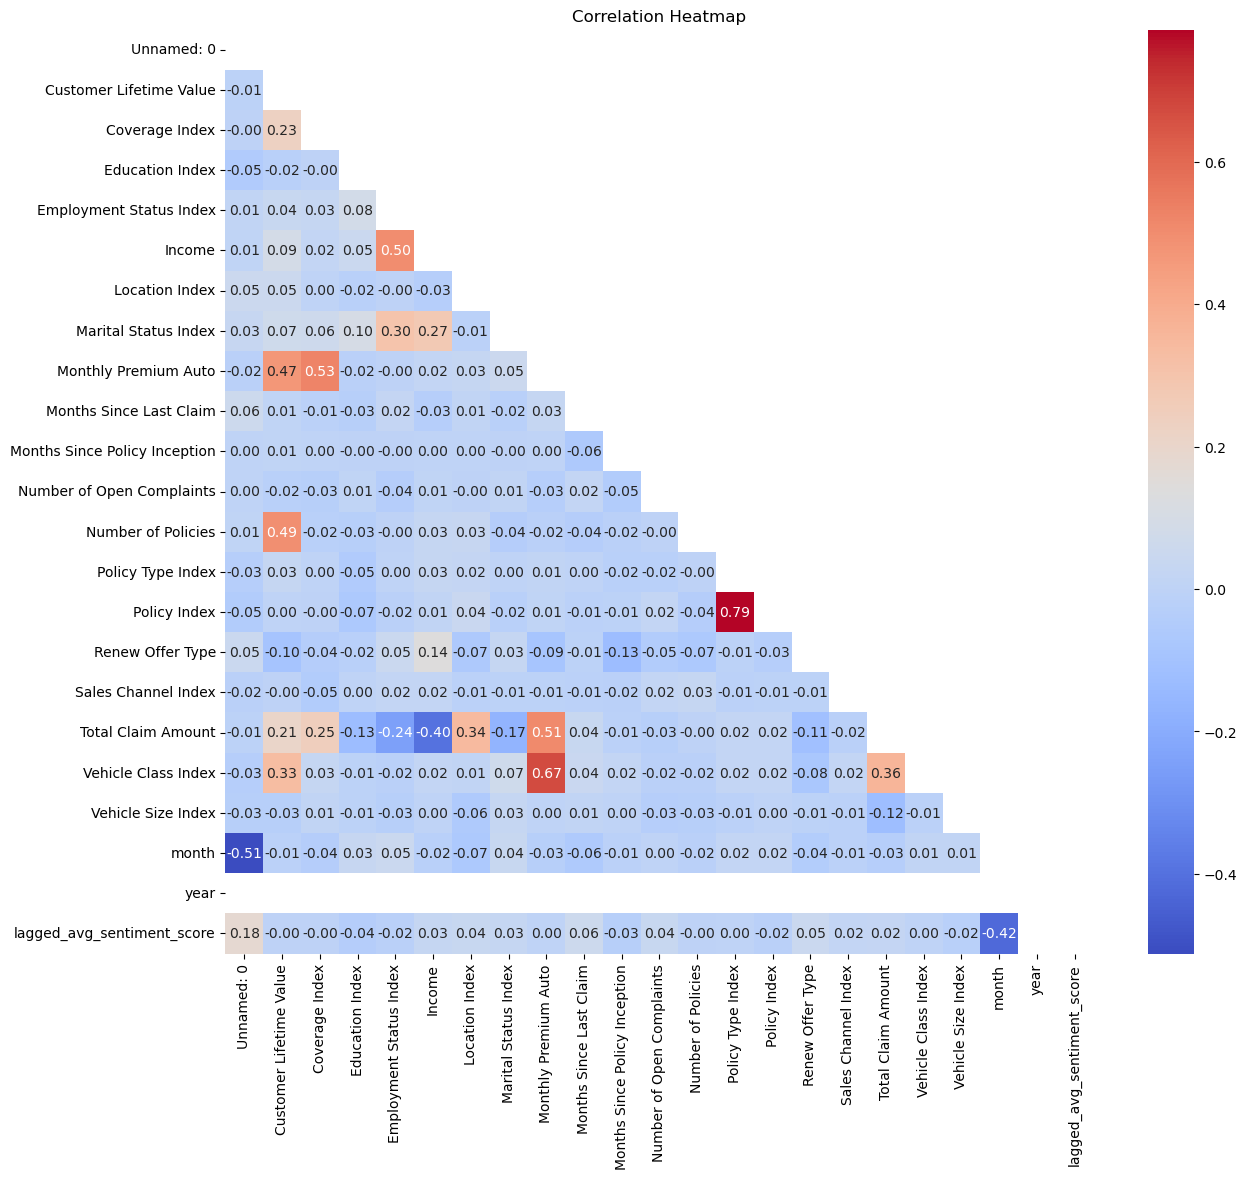

In [54]:
# Compute the correlation matrix
correlation_matrix = df.corr(method='spearman')
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Create a heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


### Filtering Out Variables with Low Variance

In [55]:
# Check standard deviation
low_variance_cols = df.std()[df.std() < 0.3].index

/var/folders/jb/_57y0k0x0wj5rxjpxc000yxc0000gn/T/ipykernel_58064/2297742091.py:2: FutureWarning:

The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.

/var/folders/jb/_57y0k0x0wj5rxjpxc000yxc0000gn/T/ipykernel_58064/2297742091.py:2: FutureWarning:

The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.



In [56]:
print("Low variance columns:", low_variance_cols)

Low variance columns: Index(['year', 'lagged_avg_sentiment_score'], dtype='object')


### Feature Selection

In [57]:
df_numeric = df.select_dtypes(include=['float64', 'int64'])
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_numeric)

X = df_numeric.drop(['Unnamed: 0', 'lagged_avg_sentiment_score', 'year', 'month'], axis=1)
y = df['lagged_avg_sentiment']

# Encode categorical target variable
le = LabelEncoder()
y = le.fit_transform(y)

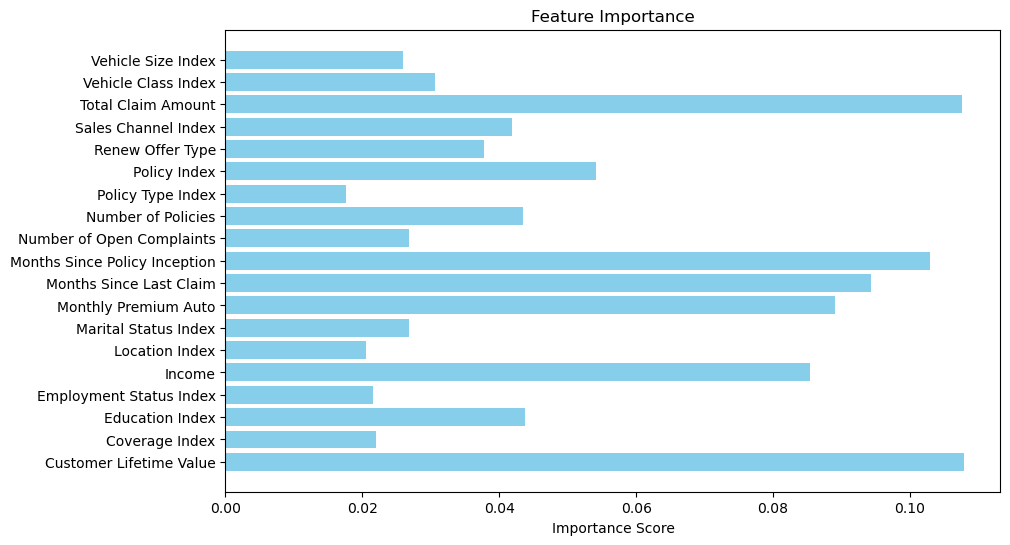

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the model
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf.fit(X_train_scaled, y_train)

y_pred = rf.predict(X_test_scaled)

# Feature importance from the model
importances = rf.feature_importances_
features = X.columns

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(features, importances, color='skyblue')
plt.xlabel('Importance Score')
plt.title('Feature Importance')
plt.show()

In [59]:
# Feature importance and corresponding features
feature_importances = {
'Customer Lifetime Value': 0.1078197162706497,
'Coverage Index': 0.021983766542722275,
'Education Index': 0.0438022231745862,
'Employment Status Index': 0.021578314932309814,
'Income': 0.08533880836102012,
'Location Index': 0.02057917406542304,
'Marital Status Index': 0.026878443379556395,
'Monthly Premium Auto': 0.08902222517414524,
'Months Since Last Claim': 0.09424962486220208,
'Months Since Policy Inception': 0.10292679555348216,
'Number of Open Complaints': 0.026825888624876497,
'Number of Policies': 0.0434765546161667,
'Policy Type Index': 0.017613337550058984,
'Policy Index': 0.05412930771195091,
'Renew Offer Type': 0.03774035239650668,
'Sales Channel Index': 0.041876868596344895,
'Total Claim Amount': 0.10764063070424754,
'Vehicle Class Index': 0.030534956323217705,
'Vehicle Size Index': 0.02598301116053306
}


In [62]:
# Convert to a pandas DataFrame for easier manipulation
df_importance = pd.DataFrame(list(feature_importances.items()), columns=['Feature', 'Importance'])

# Sort by importance
df_importance = df_importance.sort_values(by='Importance', ascending=False)

# Choose top N features (let's select the top 10 for example)
selected_features = df_importance['Feature'].head(10).values
print(selected_features)

['month' 'state_encoded' 'Customer Lifetime Value' 'Total Claim Amount'
 'Months Since Policy Inception' 'Months Since Last Claim'
 'Monthly Premium Auto' 'Income' 'Policy Index' 'Number of Policies']


### Distributions of the Variables by Cluster

/Users/sungyeonkim/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/var/folders/jb/_57y0k0x0wj5rxjpxc000yxc0000gn/T/ipykernel_58064/1752800897.py:18: FutureWarning:

Passing `palette` without assigning `hue` is deprecated.



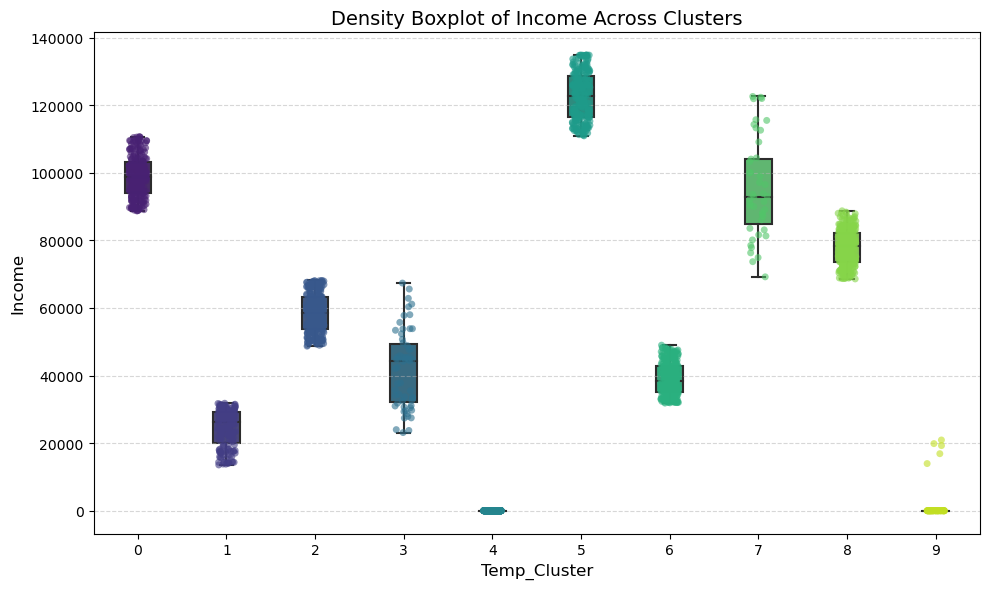

/var/folders/jb/_57y0k0x0wj5rxjpxc000yxc0000gn/T/ipykernel_58064/1752800897.py:18: FutureWarning:

Passing `palette` without assigning `hue` is deprecated.



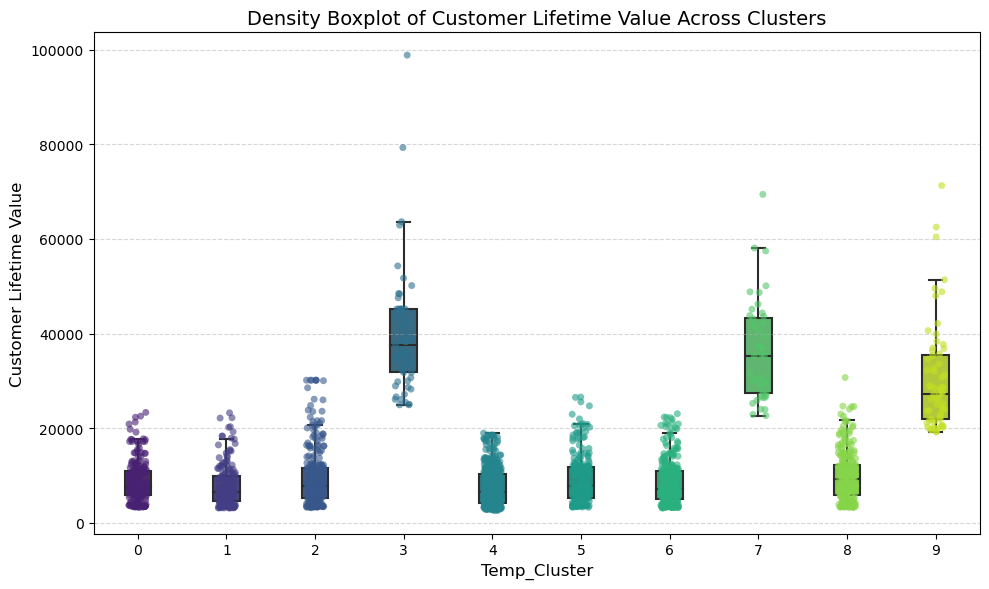

/var/folders/jb/_57y0k0x0wj5rxjpxc000yxc0000gn/T/ipykernel_58064/1752800897.py:18: FutureWarning:

Passing `palette` without assigning `hue` is deprecated.



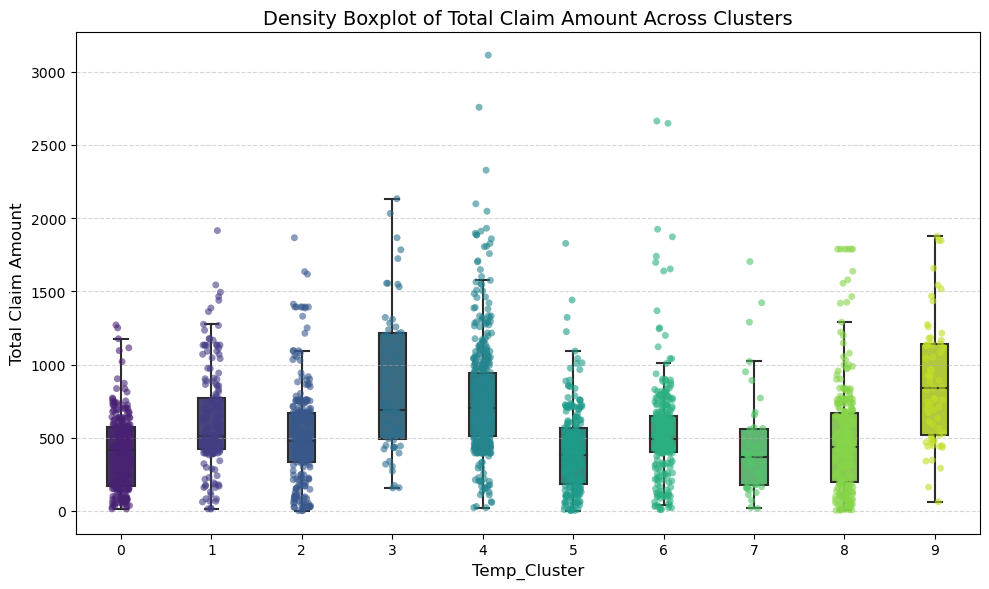

/var/folders/jb/_57y0k0x0wj5rxjpxc000yxc0000gn/T/ipykernel_58064/1752800897.py:18: FutureWarning:

Passing `palette` without assigning `hue` is deprecated.



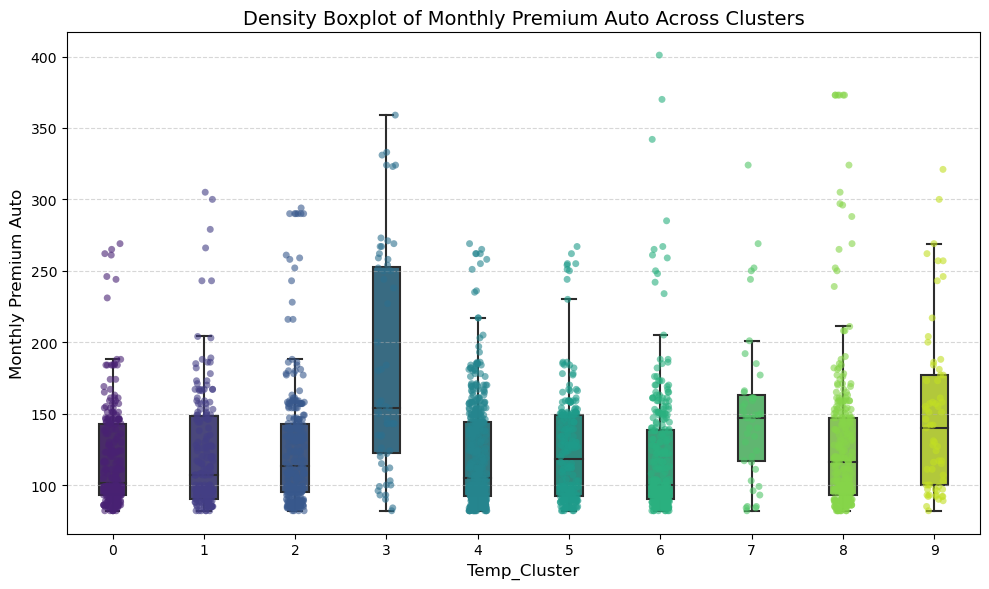

/var/folders/jb/_57y0k0x0wj5rxjpxc000yxc0000gn/T/ipykernel_58064/1752800897.py:18: FutureWarning:

Passing `palette` without assigning `hue` is deprecated.



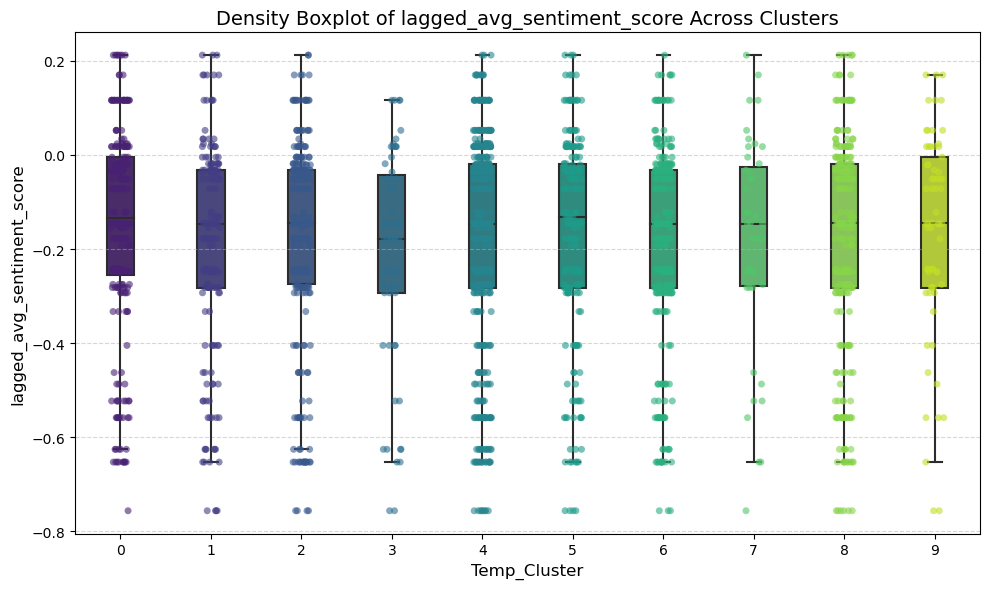

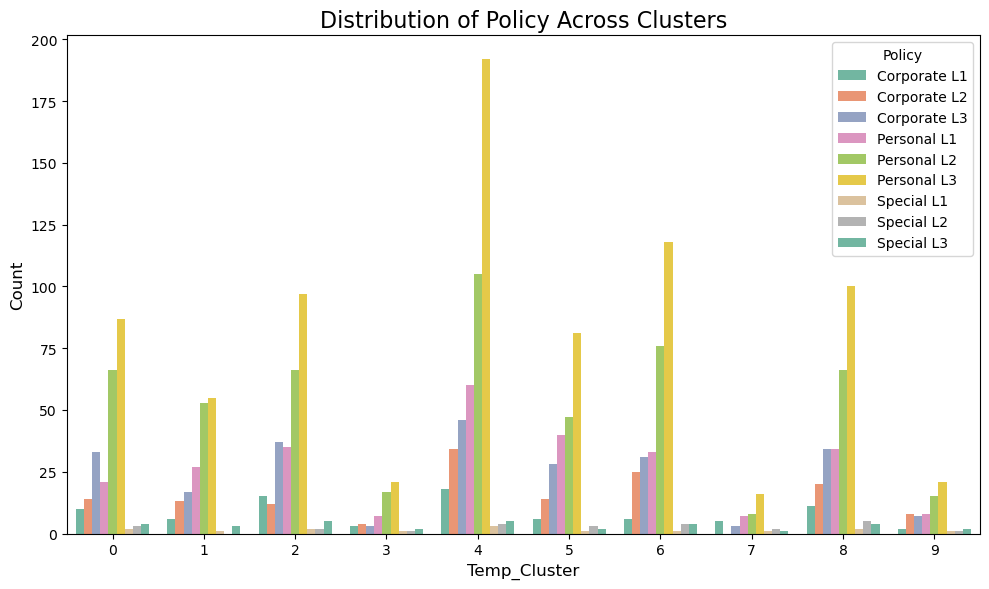

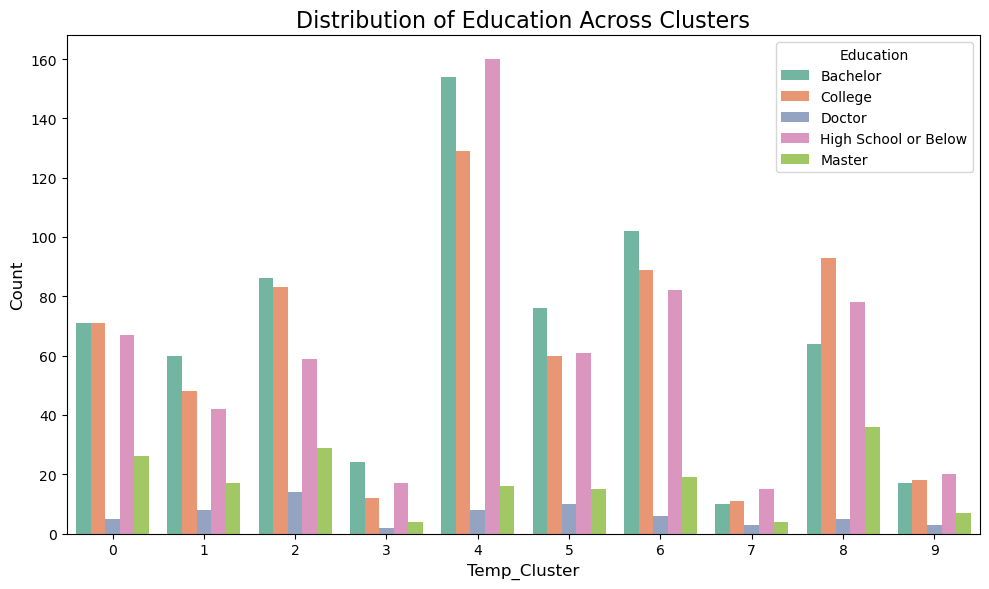

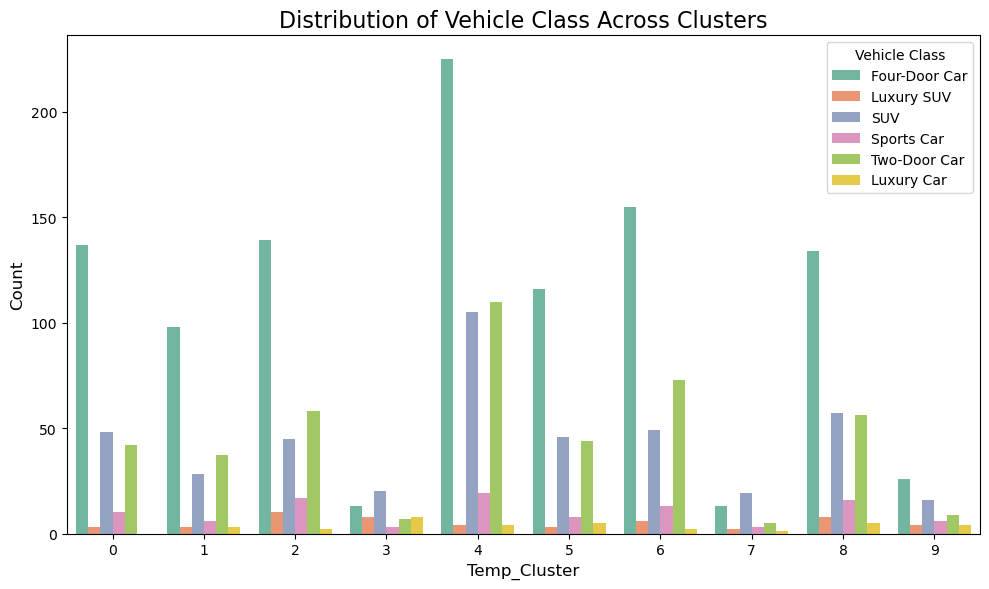

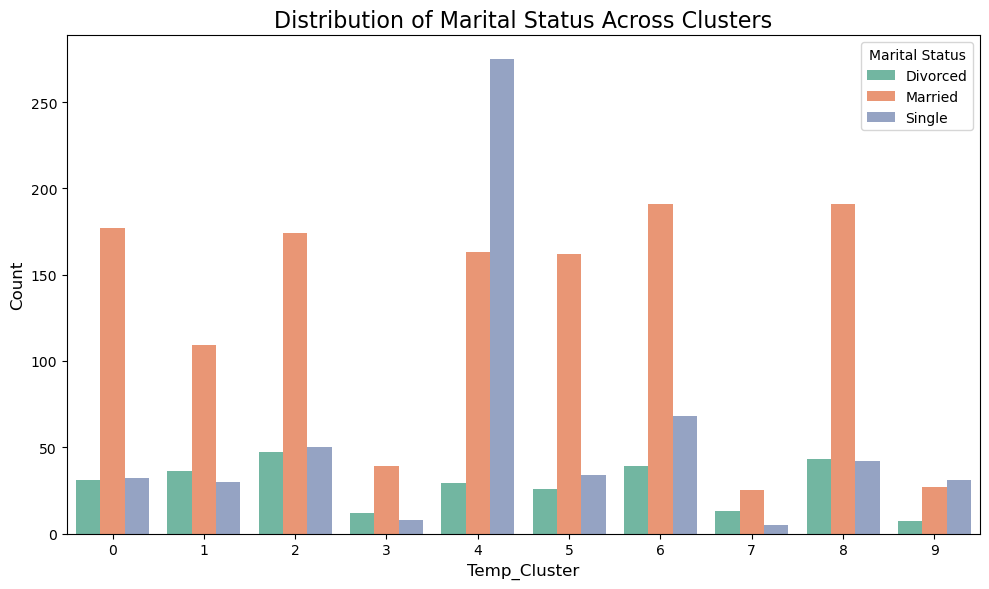

In [61]:
attributes_num = ['Income', 'Customer Lifetime Value', 'Total Claim Amount', 'Monthly Premium Auto', 'lagged_avg_sentiment_score']
attributes_cat = ['Policy', 'Education', 'Vehicle Class', 'Marital Status']

attributes_to_explore = ['Income', 'Policy Index', 'Education Index', 'Customer Lifetime Value', 'Marital Status Index',
                         'lagged_avg_sentiment_score', 'Total Claim Amount', 'Monthly Premium Auto', 'Vehicle Class Index']

kmeans = KMeans(n_clusters=10, random_state=42)
df["Temp_Cluster"] = kmeans.fit_predict(df[attributes_to_explore])

# Create density boxplots with jitter for each attribute across clusters
for attribute in attributes_num:
    plt.figure(figsize=(10, 6))
    
    # Boxplot without outliers
    sns.boxplot(x="Temp_Cluster", y=attribute, data=df, palette="viridis", showfliers=False, width=0.3)
    
    # Add jittered points for density
    sns.stripplot(x="Temp_Cluster", y=attribute, data=df, jitter=True, alpha=0.6, palette="viridis")
    
    plt.title(f"Density Boxplot of {attribute} Across Clusters", fontsize=14)
    plt.xlabel("Temp_Cluster", fontsize=12)
    plt.ylabel(attribute, fontsize=12)
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

# Plot the bar graph
for attribute in attributes_cat:
    cluster_counts = df.groupby(['Temp_Cluster', attribute]).size().reset_index(name='count')
    
    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=cluster_counts,  # Use the grouped data
        x='Temp_Cluster',
        y='count',
        hue=attribute,
        palette='Set2'
    )

    # Customize the plot
    plt.title(f'Distribution of {attribute} Across Clusters', fontsize=16)
    plt.xlabel('Temp_Cluster', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.legend(title=attribute, fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()

    # Show the plot
    plt.show()


## K-Means Clustering using t_SNE

/Users/sungyeonkim/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/sungyeonkim/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/sungyeonkim/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/sungyeonkim/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/sungyeonkim/anaconda3/lib/python3.11/site-pac

Optimal K: 2


/Users/sungyeonkim/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/sungyeonkim/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



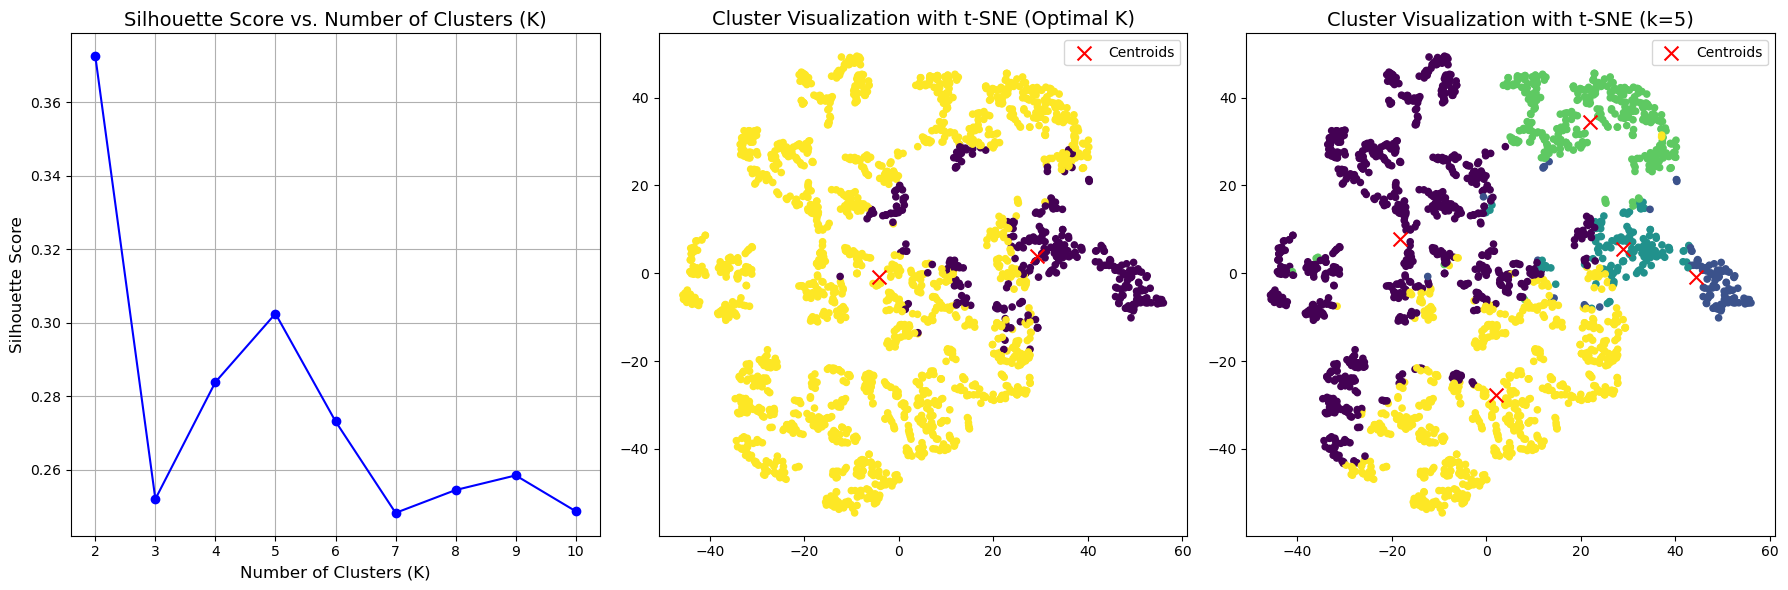

In [71]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

# Sample selected features
selected_features = ['lagged_avg_sentiment_score', 'Customer Lifetime Value', 'Income', 'Monthly Premium Auto']

# Assuming df is your original DataFrame
X = df[selected_features]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Range of K to try (convert to a list)
k_values = list(range(2, 11))

sil_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    
    # Calculate silhouette score
    score = silhouette_score(X_scaled, kmeans.labels_)
    sil_scores.append(score)

# Create figure for the subplots
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# Plot silhouette scores in the first subplot
ax[0].plot(k_values, sil_scores, marker='o', linestyle='-', color='b')
ax[0].set_title("Silhouette Score vs. Number of Clusters (K)", fontsize=14)
ax[0].set_xlabel("Number of Clusters (K)", fontsize=12)
ax[0].set_ylabel("Silhouette Score", fontsize=12)
ax[0].grid(True)

# Find the optimal K with the highest silhouette score
optimal_k = k_values[sil_scores.index(max(sil_scores))]
print(f'Optimal K: {optimal_k}')

# Perform K-Means clustering for optimal_k
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Add cluster labels to data
df['Cluster'] = clusters

# Perform t-SNE for the optimal K
tsne = TSNE(n_components=2, random_state=42)
X_embedded = tsne.fit_transform(X_scaled)

# Add t-SNE results to the dataframe
df['t-SNE_1'] = X_embedded[:, 0]
df['t-SNE_2'] = X_embedded[:, 1]

# Compute centroids in t-SNE space
centroids = df.groupby('Cluster')[['t-SNE_1', 't-SNE_2']].mean()

# Plot t-SNE visualization for optimal K (second subplot)
scatter = ax[1].scatter(df['t-SNE_1'], df['t-SNE_2'], c=df['Cluster'], cmap='viridis', s=20)
ax[1].scatter(centroids['t-SNE_1'], centroids['t-SNE_2'], marker='x', color='red', s=100, label="Centroids")
ax[1].set_title("Cluster Visualization with t-SNE (Optimal K)", fontsize=14)
ax[1].legend()

# Perform K-Means clustering for k=5
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Add cluster labels to data
df['Cluster'] = clusters

# Perform t-SNE for k=5
X_embedded = tsne.fit_transform(X_scaled)

# Add t-SNE results to the dataframe
df['t-SNE_1'] = X_embedded[:, 0]
df['t-SNE_2'] = X_embedded[:, 1]

# Compute centroids in t-SNE space
centroids = df.groupby('Cluster')[['t-SNE_1', 't-SNE_2']].mean()

# Plot t-SNE visualization for k=5 (third subplot)
scatter = ax[2].scatter(df['t-SNE_1'], df['t-SNE_2'], c=df['Cluster'], cmap='viridis', s=20)
ax[2].scatter(centroids['t-SNE_1'], centroids['t-SNE_2'], marker='x', color='red', s=100, label="Centroids")
ax[2].set_title("Cluster Visualization with t-SNE (k=5)", fontsize=14)
ax[2].legend()

# Adjust the layout to make the plot larger horizontally
plt.tight_layout()
plt.show()


I used the Silhouette score to determine the optimal number of clusters, identifying \( k=2 \) as the best choice. To visualize the clusters, I applied t-SNE for dimensionality reduction and plotted the clusters for both \( k=2 \) and a larger \( k=5 \). The t-SNE plots revealed that the clusters were not clearly separable. Additionally, upon examining the variables contributing to cluster formation, I found that `lagged_avg_sentiment_score` was not a significant factor. Since the goal was to explore the relationship between `lagged_avg_sentiment_score` and other variables, I adjusted the clustering approach to prioritize this variable and considered a larger \( k \) for better-defined clusters. Finally, I examined the correlations between `lagged_avg_sentiment_score` and variables such as `Customer Lifetime Value`, `Income`, and `Monthly Premium Auto` within each cluster, which revealed relationships between sentiment scores and these variables.

In [64]:
df_numeric = df[['lagged_avg_sentiment_score', 'Customer Lifetime Value', 'Income', 'Monthly Premium Auto', 'Cluster']]

for cluster in df_numeric['Cluster'].unique():
    print(f"Cluster {cluster}:")
    cluster_data = df_numeric[df_numeric['Cluster'] == cluster]
    print(cluster_data.corr()['lagged_avg_sentiment_score'])


Cluster 4:
lagged_avg_sentiment_score    1.000000
Customer Lifetime Value       0.014924
Income                       -0.039060
Monthly Premium Auto          0.000466
Cluster                            NaN
Name: lagged_avg_sentiment_score, dtype: float64
Cluster 0:
lagged_avg_sentiment_score    1.000000
Customer Lifetime Value       0.013525
Income                       -0.063500
Monthly Premium Auto          0.040972
Cluster                            NaN
Name: lagged_avg_sentiment_score, dtype: float64
Cluster 3:
lagged_avg_sentiment_score    1.000000
Customer Lifetime Value      -0.084488
Income                       -0.049478
Monthly Premium Auto         -0.077793
Cluster                            NaN
Name: lagged_avg_sentiment_score, dtype: float64
Cluster 1:
lagged_avg_sentiment_score    1.000000
Customer Lifetime Value      -0.128715
Income                       -0.073325
Monthly Premium Auto         -0.000165
Cluster                            NaN
Name: lagged_avg_sentiment_sc

The correlations between `lagged_avg_sentiment_score` and other variables across clusters show consistent but weak relationships. In particular, sentiment scores exhibit small negative correlations with `Income` across all clusters, suggesting that individuals with lower incomes may tend to have more positive sentiment scores. Similarly, weak negative correlations with `Customer Lifetime Value` and `Monthly Premium Auto` are observed in some clusters, with a slightly stronger negative trend for `Monthly Premium Auto` in Cluster 2. Overall, these weak correlations suggest that sentiment is only minimally influenced by these variables, and any trends may vary depending on the cluster.

## Interpretations

The analysis of lagged sentiment data reveals meaningful patterns in customer segmentation, with `Customer Lifetime Value` and `Monthly Premium Auto` emerging as significant drivers of segmentation. Customers with higher `Customer Lifetime Value`, higher `Monthly Premium Auto` payments, more comprehensive or expensive policies, and marital status tend to exhibit lower sentiment scores. This suggests that dissatisfaction among high-value customers may persist over time, potentially influencing their behavior and risk profiles in 2024. These findings highlight the predictive power of lagged sentiment data in anticipating shifts in customer satisfaction and engagement.

In contrast, customers with lower incomes display slightly higher sentiment scores, likely due to modest expectations and perceived value from more affordable policies and services. The lagged period (2023 sentiment data vs. 2024 behavior) could indicate that lower-income customers maintain consistent sentiment over time due to less fluctuation in policy complexity or cost burdens, which tend to impact higher-income segments more prominently.

These insights emphasize the value of analyzing historical sentiment data to proactively identify dissatisfaction and address emerging risks. Insurance companies can leverage these findings to implement tailored interventions, such as simplifying policies, offering loyalty rewards, and enhancing transparency. By addressing these issues, companies can improve customer satisfaction, mitigate future dissatisfaction, and foster stronger relationships with their customers.


<!-- Specifically, insurance companies could:

1. Loyalty and Incentive Programs
    - Reward long-term customers with discounts, cashback, or exclusive benefits.
<p></p>

2. Proactive Communication
    - Regularly update customers about policy changes, claims progress, and new offerings.
    - Use personalized communication to make customers feel valued and informed.
    - Use sentiment analysis on customer interactions (e.g., surveys, calls, emails) to identify pain points.
<p></p>

3. Transparency and Trust-Building
    - Clearly outline policy terms, coverage, and exclusions to avoid confusion.
    - Actively gather and implement feedback to show a commitment to customer satisfaction.
<p></p>

4. Preventive and Value-Added Services
    - Offer preventive services like risk assessments, home inspections, or telematics devices.
    - Provide tools and resources to help customers reduce risks and enhance safety.
<p></p>

5. Enhanced Customer Support
    - Expand support availability with 24/7 live chat, phone, and email services.
    - Train customer service representatives to handle complaints empathetically and effectively. -->